### Team 9 Final Project - Housing Prices

In [51]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
sns.set()
from pycaret.regression import *

import warnings
warnings.filterwarnings('ignore')

In [52]:
# Load the data
train = pd.read_csv('house-prices-advanced-regression-techniques/train.csv')
test = pd.read_csv('house-prices-advanced-regression-techniques/test.csv')
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [53]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [54]:
train.nunique()

Id               1460
MSSubClass         15
MSZoning            5
LotFrontage       110
LotArea          1073
                 ... 
MoSold             12
YrSold              5
SaleType            9
SaleCondition       6
SalePrice         663
Length: 81, dtype: int64

In [55]:
train.isna().sum()

Id                 0
MSSubClass         0
MSZoning           0
LotFrontage      259
LotArea            0
                ... 
MoSold             0
YrSold             0
SaleType           0
SaleCondition      0
SalePrice          0
Length: 81, dtype: int64

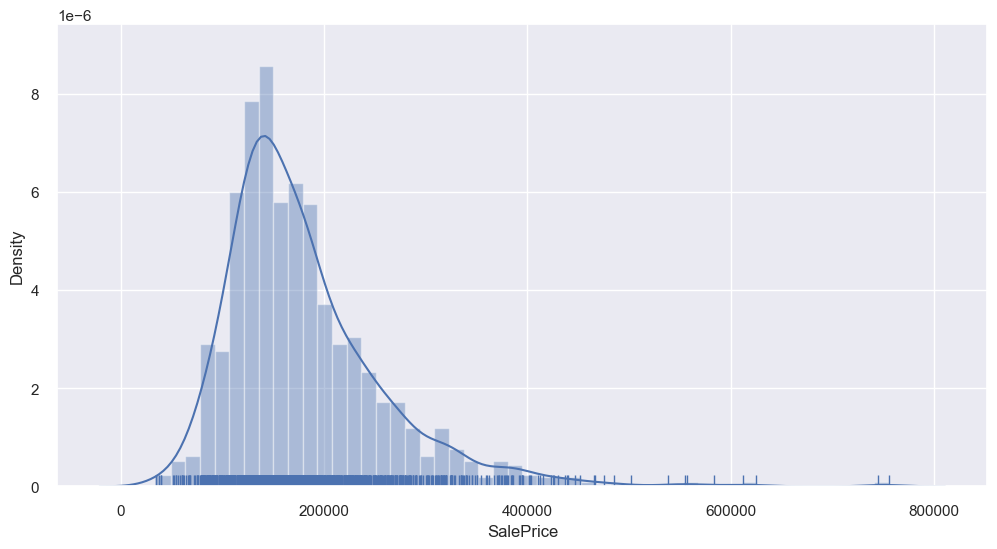

In [56]:
plt.figure(figsize=(12,6))
sns.distplot(train['SalePrice'], kde=True, bins=50, rug=True)
plt.show()

In [57]:
# Define numerical, ordinal, and categorical variables
categorical = [
    'MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
    'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
    'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
    'Exterior2nd', 'MasVnrType', 'Foundation', 'Heating', 'CentralAir',
    'Electrical', 'GarageType', 'GarageFinish', 'PavedDrive', 'Fence', 
    'MiscFeature', 'SaleType', 'SaleCondition'
]
ordinal = {
    'OverallQual': list(range(1, 11)),  # From 1 (Very Poor) to 10 (Excellent)
    'OverallCond': list(range(1, 11)),  # From 1 (Very Poor) to 10 (Excellent)
    'ExterQual': ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
    'ExterCond': ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
    'BsmtQual': ['NA', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
    'BsmtCond': ['NA', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
    'BsmtExposure': ['NA', 'No', 'Mn', 'Av', 'Gd'],
    'BsmtFinType1': ['NA', 'Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ'],
    'BsmtFinType2': ['NA', 'Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ'],
    'HeatingQC': ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
    'KitchenQual': ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
    'FireplaceQu': ['NA', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
    'PoolQC': ['NA', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
    'Functional': ['Sal', 'Sev', 'Maj2', 'Maj1', 'Mod', 'Min2', 'Min1', 'Typ'],
    'GarageQual': ['NA', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
    'GarageCond': ['NA', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
}
numeric = [
    'LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
    'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'GrLivArea',
    'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch',
    '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'YearBuilt',
    'YearRemodAdd', 'GarageYrBlt', 'MoSold', 'YrSold', 'BedroomAbvGr',
    'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageCars',
    'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath'
]
# Transform Sale Price
train['LogSalePrice'] = np.log(train['SalePrice'])
train.drop(columns=['SalePrice', 'Id'], inplace=True)

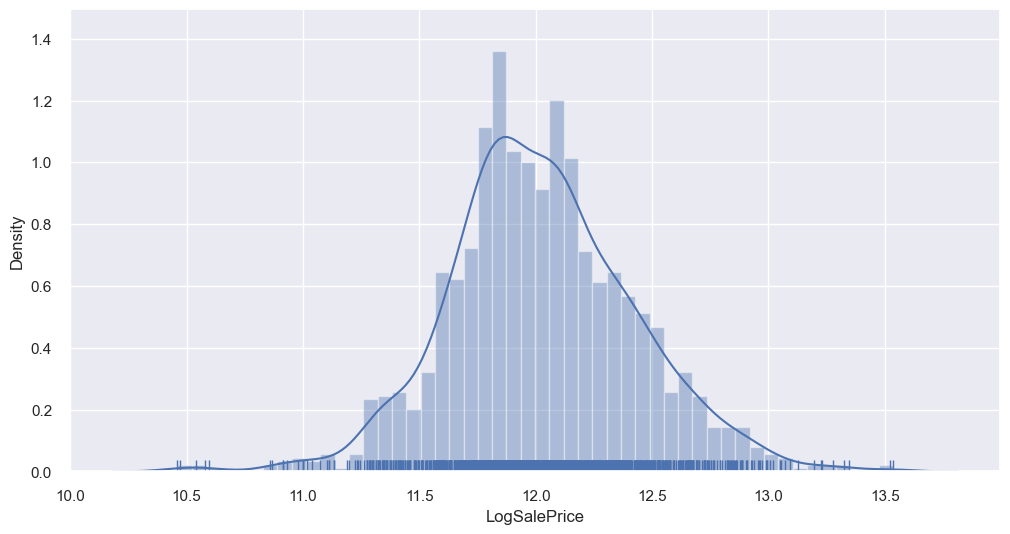

In [58]:
plt.figure(figsize=(12,6))
sns.distplot(train['LogSalePrice'], kde=True, bins=50, rug=True)
plt.show()

In [59]:
# Fill in missing variables in both train and test

# Categorical
for col in ['Alley', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 
            'BsmtFinType2', 'FireplaceQu', 'PoolQC', 'Fence', 
            'MiscFeature', 'GarageQual', 'GarageCond', 'GarageFinish', 
            'GarageType']:
    train[col].fillna('NA', inplace=True)
    test[col].fillna('NA', inplace=True)
    
train['MasVnrType'].fillna('None', inplace=True)
train['MasVnrArea'].fillna(0, inplace=True)
train['GarageYrBlt'].fillna(0, inplace=True)
lotfrontage_medians = train.groupby('Neighborhood')['LotFrontage'].median()
train['LotFrontage'] = train.groupby('Neighborhood')['LotFrontage'].transform(
    lambda x: x.fillna(x.median())
)
train = train.dropna(subset=['Electrical'])


# Numeric
test['MasVnrType'].fillna('None', inplace=True)
test['MasVnrArea'].fillna(0, inplace=True)
test['GarageYrBlt'].fillna(0, inplace=True)
global_median = train['LotFrontage'].median()
test['LotFrontage'] = test.apply(
    lambda row: lotfrontage_medians[row['Neighborhood']]
    if pd.notnull(row['Neighborhood']) and row['Neighborhood'] in lotfrontage_medians
    else global_median,
    axis=1
)
test = test.dropna(subset=['Electrical'])

# Convert nominal categorical variables to category dtype
for col in categorical:
    train_non_null = train[col].dropna()
    test_non_null = test[col].dropna()
    
    # Make sure both train and test have the same categories
    all_categories = pd.concat([train_non_null, test_non_null], axis=0).unique()
    
    # Convert the columns to category type with consistent categories
    train[col] = pd.Categorical(train[col], categories=all_categories)
    test[col] = pd.Categorical(test[col], categories=all_categories)


# Convert ordinal categorical variables with defined order
for col, order in ordinal.items():
    train[col] = pd.Categorical(train[col], categories=order, ordered=True)
    test[col] = pd.Categorical(test[col], categories=order, ordered=True)

# Convert numeric variables to appropriate numeric types
train[numeric] = train[numeric].apply(pd.to_numeric, errors='coerce')
test[numeric] = test[numeric].apply(pd.to_numeric, errors='coerce')

# Check the results
print(train.info())

<class 'pandas.core.frame.DataFrame'>
Index: 1459 entries, 0 to 1459
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   MSSubClass     1459 non-null   int64   
 1   MSZoning       1459 non-null   category
 2   LotFrontage    1459 non-null   float64 
 3   LotArea        1459 non-null   int64   
 4   Street         1459 non-null   category
 5   Alley          1459 non-null   category
 6   LotShape       1459 non-null   category
 7   LandContour    1459 non-null   category
 8   Utilities      1459 non-null   category
 9   LotConfig      1459 non-null   category
 10  LandSlope      1459 non-null   category
 11  Neighborhood   1459 non-null   category
 12  Condition1     1459 non-null   category
 13  Condition2     1459 non-null   category
 14  BldgType       1459 non-null   category
 15  HouseStyle     1459 non-null   category
 16  OverallQual    1459 non-null   category
 17  OverallCond    1459 non-null   categor

In [60]:
sum(train.duplicated())

0

In [62]:
exp = RegressionExperiment() 
exp.setup(
    train, 
    target='LogSalePrice', 
    session_id=555, 
    train_size=0.7, 
    preprocess=True,
    ordinal_features=ordinal,
    numeric_features=numeric,
    categorical_features=categorical
)

,Description,Value
0,Session id,555
1,Target,LogSalePrice
2,Target type,Regression
3,Original data shape,"(1459, 80)"
4,Transformed data shape,"(1459, 235)"
5,Transformed train set shape,"(1021, 235)"
6,Transformed test set shape,"(438, 235)"
7,Ordinal features,16
8,Numeric features,32
9,Categorical features,29


In [64]:
exp.compare_models()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
catboost,CatBoost Regressor,0.0809,0.0146,0.1189,0.9077,0.0092,0.0068,0.6140
gbr,Gradient Boosting Regressor,0.0911,0.0185,0.1329,0.8840,0.0103,0.0076,0.1220
lightgbm,Light Gradient Boosting Machine,0.0919,0.0187,0.1351,0.8831,0.0105,0.0077,0.4650
et,Extra Trees Regressor,0.0965,0.0196,0.1379,0.8773,0.0107,0.0081,0.1930
rf,Random Forest Regressor,0.0991,0.0215,0.1445,0.8663,0.0112,0.0083,0.2000
xgboost,Extreme Gradient Boosting,0.1020,0.0219,0.1458,0.8623,0.0113,0.0085,0.0970
br,Bayesian Ridge,0.0931,0.0248,0.1463,0.8376,0.0112,0.0078,0.0530
ridge,Ridge Regression,0.0934,0.0249,0.1459,0.8370,0.0111,0.0078,0.0480
ada,AdaBoost Regressor,0.1280,0.0292,0.1698,0.8159,0.0131,0.0107,0.0930
omp,Orthogonal Matching Pursuit,0.1064,0.0311,0.1665,0.7983,0.0127,0.0089,0.0450


Processing:   0%|          | 0/85 [00:00<?, ?it/s]

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.0677,0.0076,0.0873,0.9382,0.0067,0.0056
1,0.0797,0.0115,0.1071,0.9326,0.0081,0.0066
2,0.0878,0.0170,0.1304,0.8749,0.0101,0.0073
3,0.0908,0.0167,0.1291,0.9074,0.0101,0.0076
4,0.0763,0.0100,0.1000,0.9166,0.0077,0.0064
5,0.0826,0.0169,0.1302,0.8976,0.0103,0.0070
6,0.0879,0.0163,0.1276,0.9299,0.0100,0.0074
7,0.0651,0.0083,0.0911,0.9390,0.0072,0.0055
8,0.0888,0.0260,0.1611,0.8180,0.0121,0.0074


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

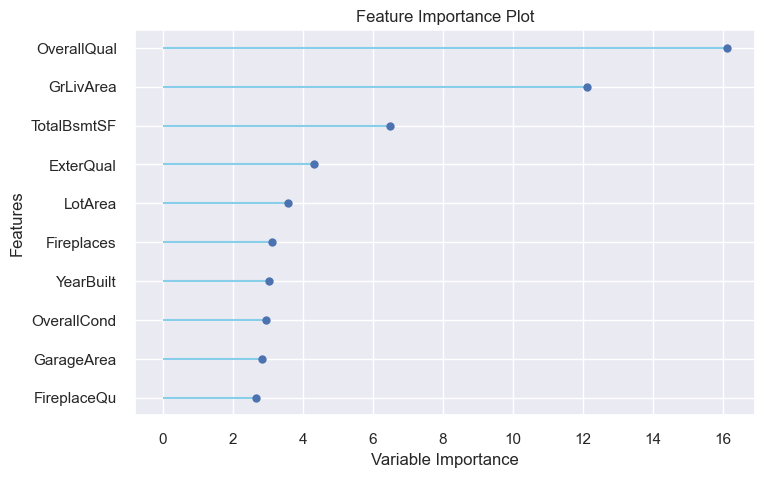

In [69]:
catboost = exp.create_model('catboost')
exp.plot_model(catboost, plot='feature')    

In [71]:
exp.tune_model(catboost, optimize='RMSE')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.0692,0.0083,0.0910,0.9328,0.0070,0.0058
1,0.0827,0.0127,0.1129,0.9251,0.0085,0.0068
2,0.0930,0.0182,0.1350,0.8660,0.0104,0.0078
3,0.0957,0.0182,0.1350,0.8986,0.0106,0.0081
4,0.0828,0.0117,0.1083,0.9021,0.0083,0.0069
5,0.0926,0.0186,0.1365,0.8874,0.0107,0.0078
6,0.0889,0.0164,0.1279,0.9296,0.0100,0.0074
7,0.0709,0.0092,0.0961,0.9321,0.0076,0.0060
8,0.0899,0.0282,0.1678,0.8026,0.0126,0.0075


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


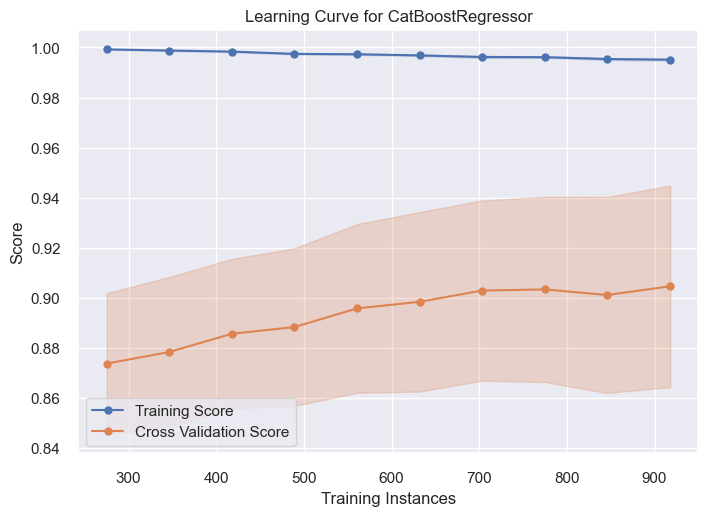

In [72]:
exp.plot_model(catboost, plot='learning')

We would need more observations to improve the cross validation score.